In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import logit, expit


def rescale_beta(x, lower=-3, upper=3):
    res = (x - lower) / (upper - lower)
    return((res * (len(x) - 1) + .5) / len(x))


def standardize(x):
    return( (x - np.mean(x))/np.std(x) )

df = pd.read_csv("data/s1-data.csv")

df = df.apply(standardize)
# df = df.apply(rescale_beta).apply(logit).apply(standardize)

train, test = train_test_split(df.to_numpy(), test_size=0.2, random_state = 123)

df.head()


,diseaseRare,diseaseSevere,hb,infantImmLimCap,infantImmWeak,medSkept,nat,overpar,parentExpert,vaccDanger,vaccEff,vaccIntent,vaccStrain,vaccTox
0,1.513743,0.349602,1.112192,-0.370259,-1.343816,-1.384762,0.115226,-0.051236,0.383666,-1.237144,0.363309,0.788035,-0.404044,-1.271407
1,-1.744974,1.136251,0.329358,1.867916,2.088321,1.888120,1.164339,0.861150,1.387124,1.701806,-1.960636,-1.534514,2.780358,2.428993
2,-0.115615,0.152940,0.133650,-0.542426,-0.036335,-0.194623,-0.334394,0.313719,0.383666,-0.318723,-0.217677,0.013852,-0.244824,-0.766807
3,0.970623,-1.223696,0.720775,-0.025924,-0.199770,-0.194623,0.414972,-0.051236,0.049180,0.416015,-0.992325,-1.224841,0.392057,0.242393
4,0.608544,-0.240384,1.699316,-0.714593,0.290535,0.102912,0.265099,0.131241,0.216423,1.334437,-1.379650,-1.224841,1.028937,1.419793


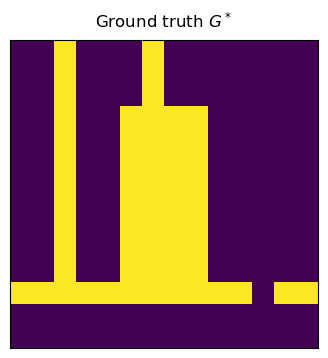

In [169]:
bl = pd.read_csv("data/theory-bl.csv")
bl = bl[df.columns.to_list()].to_numpy()
visualize_ground_truth(bl)


In [170]:
import torch
from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear
import matplotlib.pyplot as plt

class DagmaMLP2(DagmaMLP):

    def __init__(self, blackadj = None, **kwargs): # replace with 
        
        super().__init__(**kwargs)
        if blackadj is None:
            self.blackadj = torch.zeros(self.d, self.d).detach()
        else:
            self.blackadj = blackadj.detach()

    def h_func(self, s: float = 1.0) -> torch.Tensor:
        r"""
        Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG

        Parameters
        ----------
        s : float, optional
            Controls the domain of M-matrices, by default 1.0

        Returns
        -------
        torch.Tensor
            A scalar value of the log-det acyclicity function :math:`h(\Theta)`.
        """
        
        fc1_weight = self.fc1.weight
        fc1_weight = fc1_weight.view(self.d, -1, self.d)
        A = torch.sum(fc1_weight ** 2, dim=1).t()  # [i, j]
        h = -torch.slogdet(s * self.I - A)[1] + self.d * np.log(s) # +inf when not a DAG

        return h + ((A * self.blackadj).sum())*1e16


class DagmaLinear2(DagmaLinear):

    def predict(self, X = None):
        if X is None:
            X = self.X

        return X @ self.W_est


def adj_to_edge_tuple(x):
    bl_list = np.stack(np.nonzero(x), axis=-1).tolist()
    return(tuple(tuple(sub) for sub in bl_list))


def visualize_adj_matrix(mat, size=4.0):
    """    
    `mat`: (d, d) 
    """
    ## from DIBS library: https://github.com/larslorch/dibs/tree/master
    plt.rcParams['figure.figsize'] = [size, size]
    fig, ax = plt.subplots(1, 1)
    ax.matshow(mat, vmin=0, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_title(r'Graph $G^*$', pad=10)
    plt.show()
    return



## Linear model

In [171]:
model = DagmaLinear2(loss_type='l2') # create a linear model with least squares loss
W_est = model.fit(train, lambda1=0.02, w_threshold = .1, exclude_edges = adj_to_edge_tuple(bl)) # fit the model with L1 reg. (coeff. 0.02)


  0%|          | 0/180000.0 [00:00<?, ?it/s]

In [172]:
np.mean((train - model.predict(torch.tensor(train)).detach().numpy())**2), np.mean((test - model.predict(torch.tensor(test)).detach().numpy())**2)

(0.6350797475276595, 0.6351328766944406)

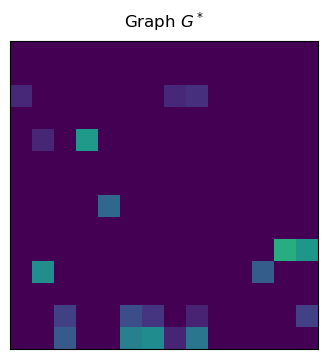

20

In [173]:
visualize_adj_matrix(W_est)
(W_est > 0).sum()

## Non-linear model

In [178]:
eq_model = DagmaMLP2(dims=[14, 20, 1], bias=True, dtype=torch.double, blackadj = torch.tensor(bl)) # create the model for the structural equations, in this case MLPs
model = DagmaNonlinear(eq_model, dtype=torch.double) # create the model for DAG learning
W_est = model.fit(train, lambda1=0.02, lambda2=0.005, w_threshold=.1) # fit the model with L1 reg. (coeff. 0.02) and L2 reg. (coeff. 0.005)

  0%|          | 0/230000.0 [00:00<?, ?it/s]

In [180]:
np.mean((train - model.model(torch.tensor(train)).detach().numpy())**2), np.mean((test - model.model(torch.tensor(test)).detach().numpy())**2)

(0.6273832594128869, 0.6251658273769235)

## Visualizing results

From the non-linear model.

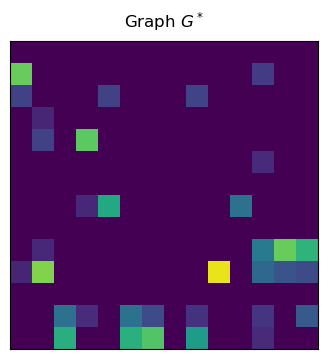

34

In [181]:
visualize_adj_matrix(W_est)
(W_est > 0).sum()